In [193]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl

# OBTENDO DADOS

In [194]:
df = pd.read_csv('DataBase.csv')
print('size:', len(df))
df.head()

size: 15000


,time,input,output
0,0.000000,50.0,0.000000
1,0.000467,50.0,-0.012376
2,0.000933,50.0,0.017691
3,0.001400,50.0,0.039704
4,0.001867,50.0,0.097024


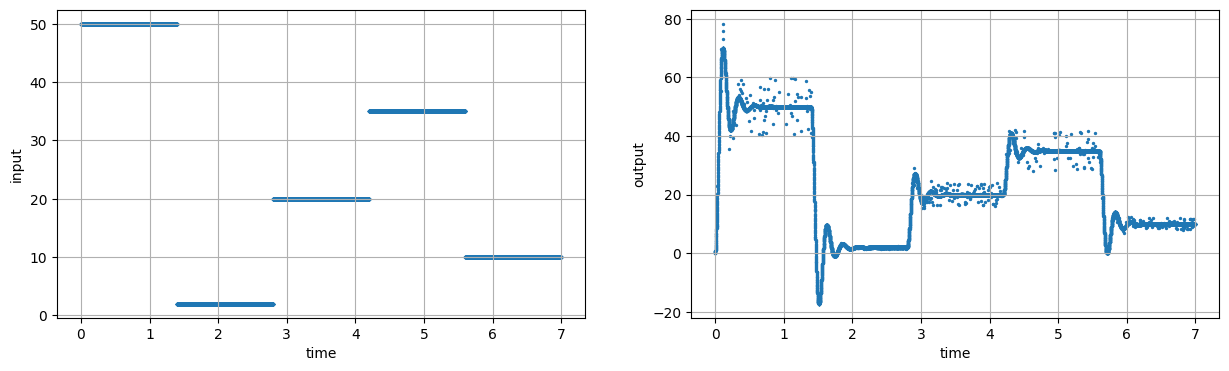

In [195]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.scatter(df.time, df.input, s=2)
plt.xlabel('time'), plt.ylabel('input')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.xlabel('time'), plt.ylabel('output')
plt.grid()

# PADRONIZANDO OS DADOS

In [196]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})
     

dt = 0.001
df = normalizeTable(df, 'time', dt)
df

,time,input,output
0,0.000,50.0,0.000000
1,0.001,50.0,0.017691
2,0.002,50.0,0.097024
3,0.003,50.0,0.121649
4,0.004,50.0,0.302253
...,...,...,...
6996,6.996,10.0,10.045288
6997,6.997,10.0,10.020238
6998,6.998,10.0,10.039173
6999,6.999,10.0,10.049251


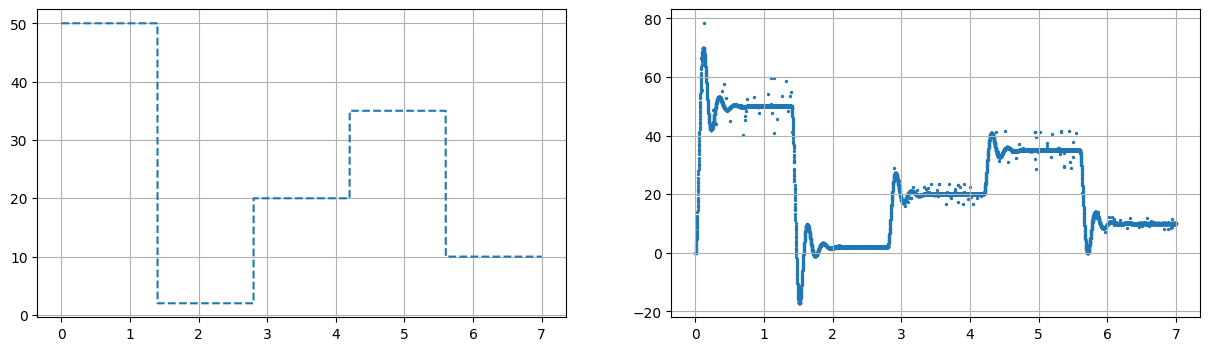

In [197]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df.time, df.input, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.grid()

In [198]:
tData, uData, yData = df.time.values, df.input.values, df.output.values

# FILTRANDO OS DADOS
- **Filtro de Savitzky-Golay**: Este filtro ajusta um polinômio de baixa ordem a uma janela deslizante de pontos de dados, preservando a forma geral dos dados (como picos e vales) enquanto suaviza o ruído. Ideal para preservar as características da curva.

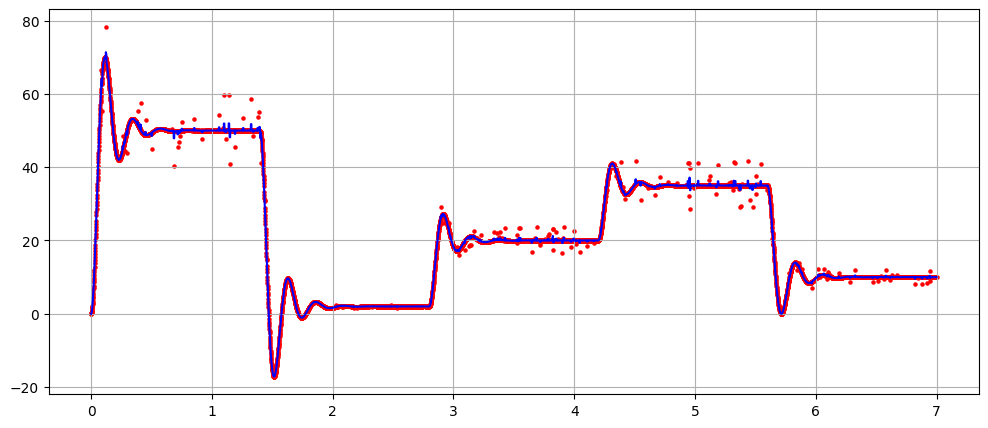

In [199]:
from scipy.signal import savgol_filter
yGolay= savgol_filter(yData, window_length=5, polyorder=1)
plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yGolay, color='blue')
plt.grid()

- **Filtro de Média Móvel**: Esse é um filtro simples e eficaz, que substitui cada ponto de dados pela média dos pontos em uma janela móvel.

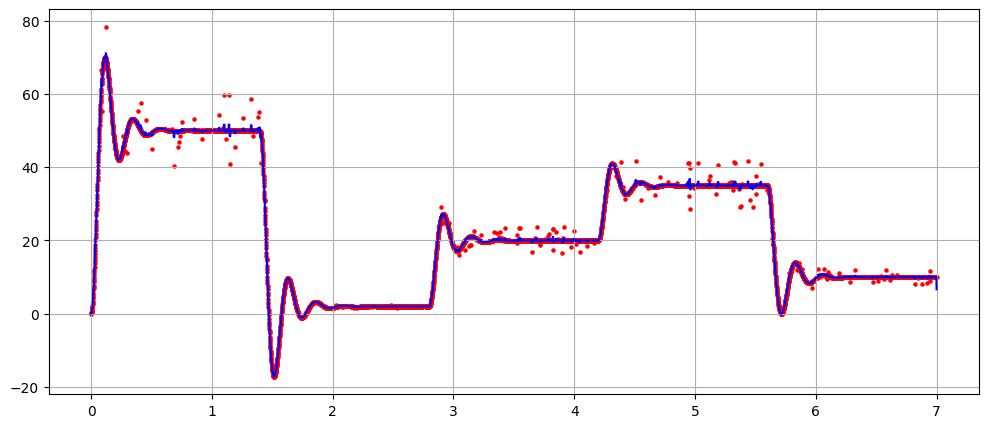

In [200]:
from numpy import convolve
windowSize = 6
yMean = convolve(yData, np.ones(windowSize) / windowSize, mode='same')

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yMean, color='blue')
plt.grid()

- **Filtro Gaussiano**: Esse filtro aplica uma função gaussiana aos dados em uma janela, o que resulta em uma suavização mais natural e contínua.

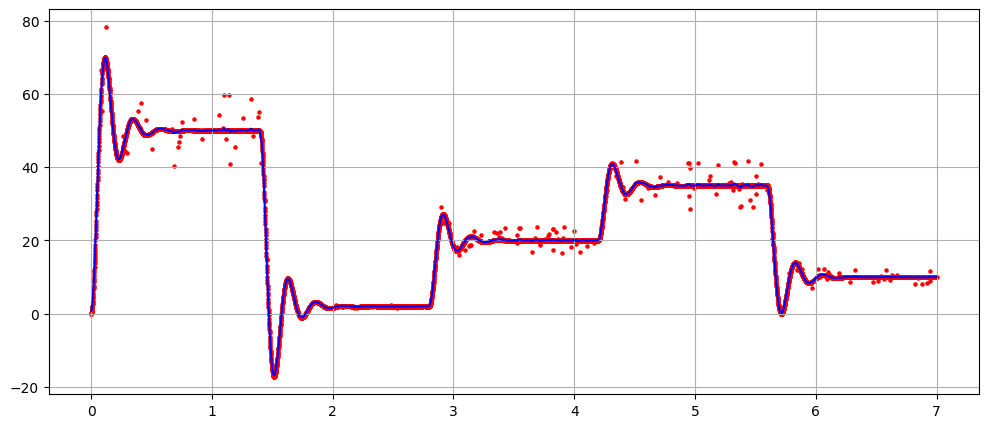

In [201]:
from scipy.ndimage import gaussian_filter
yGaussian = gaussian_filter(yData, sigma=7)

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yGaussian, color='blue')
plt.grid()

- **Filtro de Média Exponencial**: Esse método dá mais peso aos valores mais recentes, o que é útil para séries temporais.

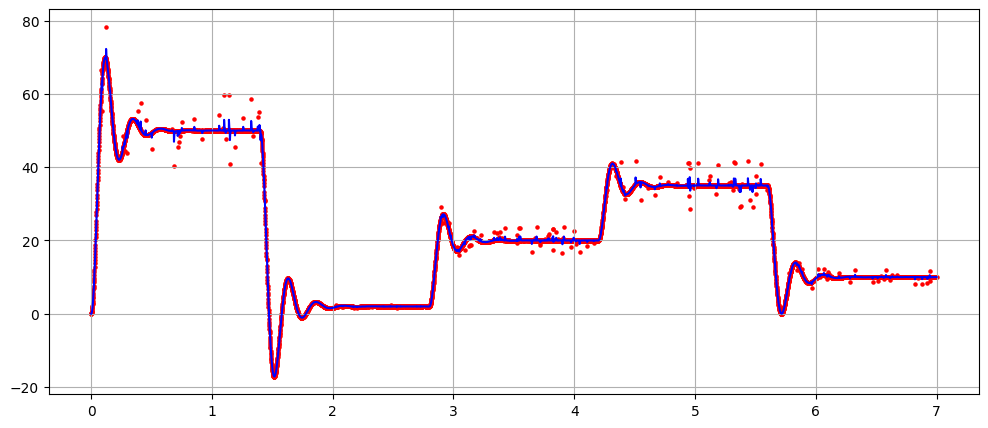

In [202]:
yExpon = pd.Series(yData).ewm(alpha=0.3).mean().to_numpy()

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yExpon, color='blue')
plt.grid()

- **Filtro de Butterworth**: É um filtro passa-baixas que elimina componentes de alta frequência e é muito usado para sinais onde queremos eliminar ruídos de alta frequência.

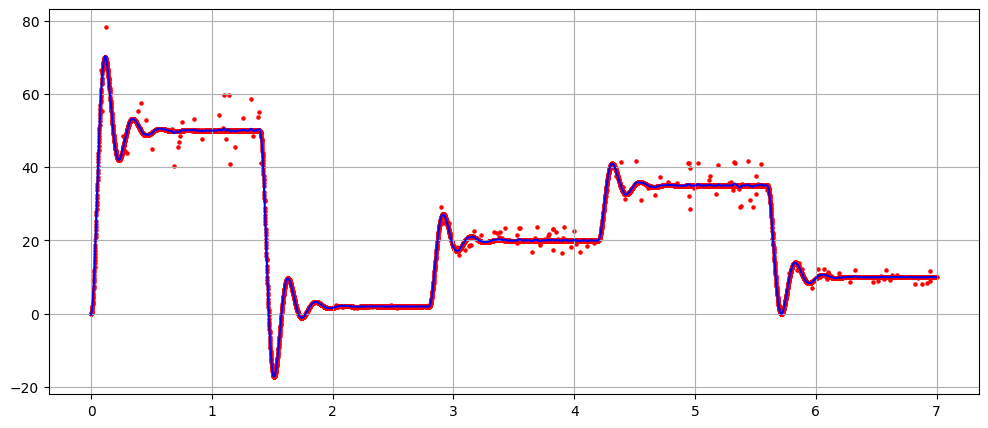

In [203]:
from scipy.signal import butter, filtfilt

order = 2           # Ordem do filtro
cutoff_freq = 0.05  # Frequência de corte (ajuste conforme seu sinal)
b, a = butter(order, cutoff_freq, btype='low', analog=False)
yButterworth = filtfilt(b, a, yData)

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yButterworth, color='blue')
plt.grid()

**Escolhendo o Filtro de Melhor Desempenho**

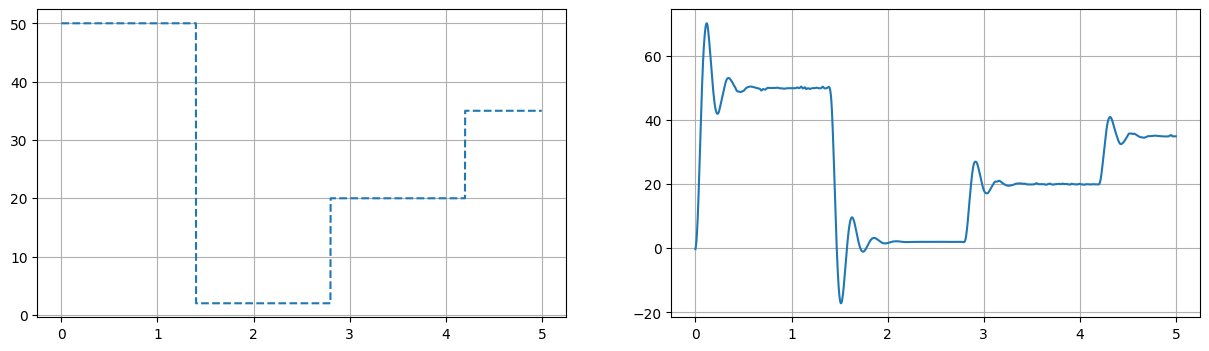

In [204]:
df['output'] = yButterworth
df = df.loc[df.time < 5]

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df.time, df.input, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.output)
plt.grid()

# DATA FITTING
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$, podemos encontrar $y(t)$ usando data fitting, encontrando uma função própria que se encaixe nos dados

In [205]:
tData, uData, yData = df.time.values, df.input.values, df.output.values

In [206]:
def g(u, a, b, c):
    s = ctl.TransferFunction.s
    G = a/(s**2 + b*s + c)
    return ctl.forced_response(G, T=tData, U=u)[1]

def getFunction(xDados, yDados):
    coeficientes = curve_fit(g, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [207]:
coefs = getFunction(uData, yData)  
coefs

[np.float64(815.5158354405932),
 np.float64(15.990980439172965),
 np.float64(815.3560026236416)]

In [208]:
s = ctl.TransferFunction.s
a, b, c = coefs

G = a/(s**2 + b*s + c)
G

TransferFunction(array([815.51583544]), array([  1.        ,  15.99098044, 815.35600262]))

### CONFERINDO COM A DATABASE

In [209]:
df = pd.read_csv('DataBase.csv')
tData, uData, yData = df.time.values, df.input.values, df.output.values

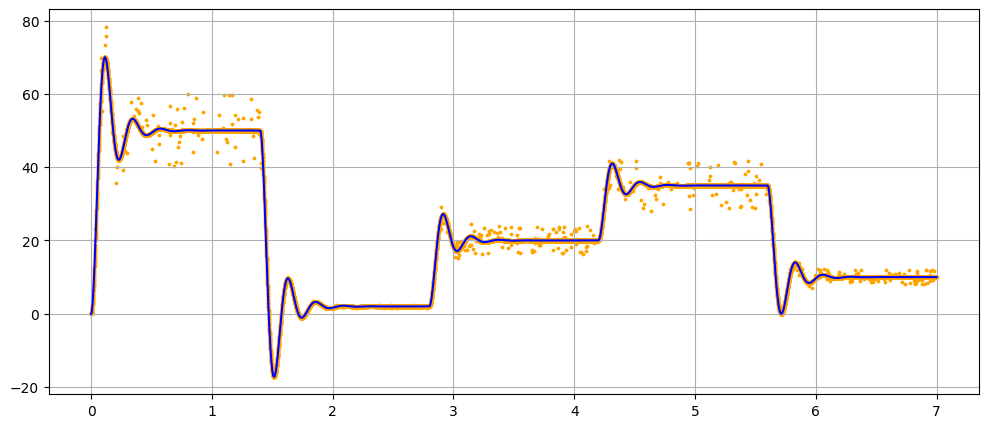

In [210]:
time, response = ctl.forced_response(G, T=tData, U=uData)

plt.figure(figsize=(12, 5))
plt.plot(time, response, color='blue')
plt.scatter(time, yData, color='orange', s=3)
plt.grid()

In [211]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

print(sympyFunction(G))

815.515835440593/(1.0*s**2 + 15.990980439173*s + 815.356002623642)
